In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect

pd.set_option('display.max_columns', None)

engine = db_connect()

# bring in the data
main_df = pd.read_sql('SELECT * FROM combined_data', con=engine)

# function to mark whether a school was operational all five years of data
# creates our 'Currently operational' feature
def mark_always_operational(main_df):
    
    total_years = main_df['SURVYEAR'].nunique()
    
    main_df['SY_STATUS_TEXT'] = main_df['SY_STATUS_TEXT'].str.strip()
    
    operational_counts = (
        main_df[main_df['SY_STATUS_TEXT'] == 'Currently operational']
        .groupby('NCESSCH')['SURVYEAR']
        .nunique()
    )
    
    always_operational_schools = operational_counts[operational_counts == total_years].index
    
    main_df['concurrently_operational'] = main_df['NCESSCH'].isin(always_operational_schools)
    
    return main_df

# apply the function
mark_always_operational(main_df=main_df)

# drop records that were not fully operational across all five years
main_df = main_df[main_df['concurrently_operational'] != False]

# strip whitespace
for col in main_df.select_dtypes(include=["string"]).columns:
    main_df[col] = main_df[col].str.strip()

# begin defining data type conversion processes
# Change columns to floats
float_cols = ["X", "Y", "LATCOD", "LONCOD", "FTE", "STUTERATIO"]

# change columns to int
int_cols = [
    "OBJECTID", "GSLO", "GSHI",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT",
    "PK", "KG", "G01", "G02", "G03", "G04", "G05", "G06",
    "G07", "G08", "G09", "G10", "G11", "G12", "G13",
    "UG", "AE",
    "TOTMENROL", "TOTFENROL", "TOTAL", "MEMBER",
    "AMALM", "AMALF", "AM",
    "ASALM", "ASALF", "AS",
    "BLALM", "BLALF", "BL",
    "HPALM", "HPALF", "HP",
    "HIALM", "HIALF", "HI",
    "TRALM", "TRALF", "TR",
    "WHALM", "WHALF", "WH"
]

# Change columns to strings
string_cols = [
    "NCESSCH", "SURVYEAR", "STABR", "LEAID", "ST_LEAID",
    "LEA_NAME", "SCH_NAME",
    "LSTREET1", "LSTREET2", "LCITY", "LSTATE",
    "LZIP", "LZIP4", "PHONE",
    "VIRTUAL", "SCHOOL_LEVEL", "SCHOOL_TYPE_TEXT",
    "STATUS", "SY_STATUS_TEXT", "ULOCALE", "NMCNTY",
    "CHARTER_TEXT", "LSTREET3", "TITLEI", "STITLEI", "MAGNET_TEXT"
]

# function to clean NCES error codes
def clean_nces_error_codes(main_df, cols):
    error_values = [
    "M", "N", "-1", "-2", "-9",
    "Missing", "Not applicable", "Not Applicable",
    -1, -2, -9
]
    main_df[cols] = main_df[cols].replace(error_values, np.nan)
    return main_df

# clean ALL columns 
cols = float_cols + int_cols + string_cols
main_df = clean_nces_error_codes(main_df, cols)

# convert floats safely
for col in float_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce")

    # convert ints safely
for col in int_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce").astype("Int64")

    # convert strings
for col in string_cols:
    main_df[col] = main_df[col].astype("string")

    # round coordinates
main_df["LATCOD"] = main_df["LATCOD"].round(4)
main_df["LONCOD"] = main_df["LONCOD"].round(4)

# extract start Year - convert to int for sorting
main_df['SURVYEAR'] = main_df['SURVYEAR'].str[:4].astype(int)

# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

# replace na values with 0
main_df = main_df.fillna(0)

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"1. main_df shape: {main_df.shape}")

# Simplify ULOCALE
main_df["locale_category"] = main_df["ULOCALE"].str.split("-").str[1].str.split(":").str[0]

# Drop the ULOCALE feature because we now have our simplified locale_category feature
main_df.drop(columns='ULOCALE', inplace=True)

# Title I rough breakdown:

# Participating:
# 1 - Yes - School participates in Title I funding / programs
# 5 - Title I schoolwide school - ENTIRE school recieves Title I support. Funds can be used for all students
# 2 - Title I targeted assistance school - Only SPECIFIC eligible students recieve services (usually low-income or academically at risk)

# Eligible, but no program running:
# 4 - Title I schoolwide eligible school - no program - Enough low-income students to qualify for schoolwide funding, but not using it
# 1 - Title I targeted assistance eligible school - No program - Eligible for targeted assistance but not participating

# Hybrid
# 3 Title I schoolwide eligible - Title I targeted assitance program - School qualifies for schoolwide funding but has chosen to run only a targeted program

# Explicit non-participation
# 2 - No - School does not participate
# 6 - Not a Title I school

# 0
# 0 - Assuming missing, unknown, or not reported


# Conceptual differences:
# Schoolwide = whole school qualifies = High funding flexibility - Typical poverty threshold >= 40% low-income
# Targeted = only some students qualify = Limited funding flexibility - lower threshold for poverty

# standardize TITLEI
schoolwide = ['1-Yes', '5-Title I schoolwide school']
targeted = ['2-Title I targeted assistance school', '3-Title I schoolwide eligible-Title I targeted assistance program']
elig_no_participate = ['4-Title I schoolwide eligible school-No program', 
                       '1-Title I targeted assistance eligible school-No program']
not_elig = ['2-No', '6-Not a Title I school']
missing = [0]

def group_titlei(col_TITLEI):
    if col_TITLEI in missing:
        return "Unknown"
    elif col_TITLEI in schoolwide:
        return "Schoolwide"
    elif col_TITLEI in targeted:
        return "Targeted"
    elif col_TITLEI in elig_no_participate:
        return "Eligible_No_Program"
    elif col_TITLEI in not_elig:
        return "Not_Eligible"
    else:
        return "Error"
    
# apply the above function to main_df
main_df['TITLEI_GROUPED'] = main_df['TITLEI'].apply(group_titlei)

# standardize STITLEI
STITLEI_yes = ['1-Yes', 'Yes']
STITLEI_no = ['2-No', 'No']
STITLEI_unknown = [0]

def standardize_STITLEI(col_STITLEI):
    if col_STITLEI in STITLEI_yes:
        return 'Yes'
    elif col_STITLEI in STITLEI_no:
        return 'No'
    elif col_STITLEI in STITLEI_unknown:
        return 'Unknown'
    else:
        return 'Error'
    
# apply the above function to main_df    
main_df['STITLEI'] = main_df['STITLEI'].apply(standardize_STITLEI)

# update the contradticions between TITLEI and STITLEI (Updating the below to 'Targeted' group instead of 'Schoolwide')
main_df.loc[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No'), 'TITLEI_GROUPED'] = 'Targeted'

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"2. main_df shape: {main_df.shape}")

# further filtering on positive student teacher ratios
main_df = main_df[main_df['STUTERATIO'] != 0.0]

# define additional redundant columns
redundant_cols = ['X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 
                  'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 
                  'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF', 
                  'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI'
                  , 'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL',
                  'concurrently_operational', 'TITLEI', 'STITLEI', 'MEMBER']

# drop additional redundant cols
main_df = main_df.drop(columns=redundant_cols)

# remove the large Alaska homeschool support program from data set
main_df[main_df['NCESSCH'] != '20013000253']

# trim the top percentile off
def trim_top_percentile(df, col="STUTERATIO", percentile=0.99):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim
    df_trimmed = df[df[col] <= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nTop values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=False)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed

# apply the above function to main_df
main_df = trim_top_percentile(main_df, col="STUTERATIO", percentile=0.99)

# trim the bottom percentile off
def trim_bottom_percentile(df, col="STUTERATIO", percentile=0.01):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim bottom values
    df_trimmed = df[df[col] >= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nBottom values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=True)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed

main_df = trim_bottom_percentile(main_df)

# create our high-strain feature
main_df["high_strain"] = (main_df["STUTERATIO"] > 20).astype(int)

# keeping all records with 5 years of data
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"3. main_df shape: {main_df.shape}")

Connection successful
1. main_df shape: (202600, 80)
2. main_df shape: (202600, 81)
99.0th percentile cutoff: 28.46
Rows before: 198008
Rows after: 196028
Rows removed: 1980

Top values after trimming:
             NCESSCH  SURVYEAR        FTE  STUTERATIO
491480  390437500293      2017  13.000000       28.46
185694  320006000591      2020  56.000000       28.46
490336  390461104403      2017  17.500000       28.46
199703  350165001122      2020   9.700000       28.45
96789   470014802171      2022  15.830000       28.43
177322  120165001822      2021   7.000000       28.43
83303   390468902689      2022  18.540001       28.43
239500  370504002912      2021   7.530000       28.42
163593  271824000964      2020  26.209999       28.42
185737  320006000730      2020  62.000000       28.42
1.0th percentile cutoff: 6.00
Rows before: 196028
Rows after: 194103
Rows removed: 1925

Bottom values after trimming:
             NCESSCH  SURVYEAR   FTE  STUTERATIO
215945  290000901215      2021   1.0

In [127]:
main_df["high_strain"] = (main_df["STUTERATIO"] > 20).astype(int)

In [128]:
main_df.shape

(184405, 41)

In [129]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain
0,40168000101,2020,401680,Cartwright Elementary District (4282),Palm Lane,No,0,0,0,0,0,106,104,98,108,100,99,132,1,4,0,0,0,0,0,0,752,43.330002,17.36,9,2,30,0,683,7,21,33.4705,-112.1975,City,Schoolwide,0


<Axes: xlabel='TOTAL', ylabel='Count'>

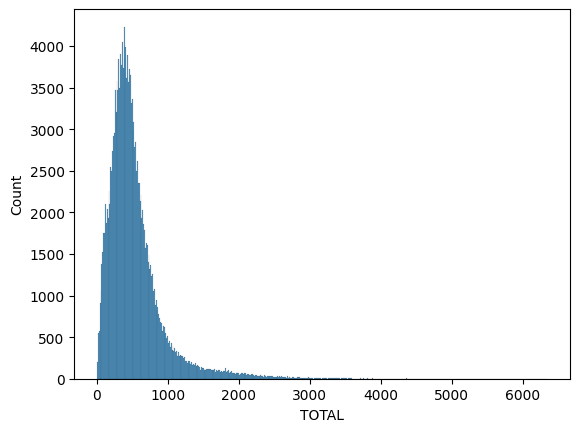

In [130]:
sns.histplot(data=main_df, x='TOTAL')

In [132]:
main_df['STUTERATIO'].describe()

count    184405.000000
mean         15.171222
std           3.464059
min           6.000000
25%          12.810000
50%          15.040000
75%          17.370000
max          28.460000
Name: STUTERATIO, dtype: float64

<Axes: xlabel='STUTERATIO', ylabel='Count'>

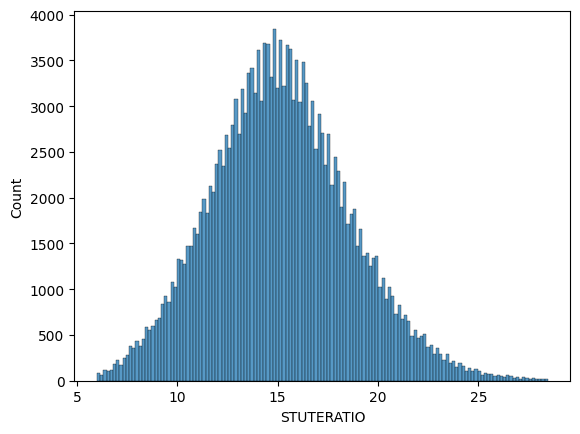

In [133]:
sns.histplot(data=main_df, x='STUTERATIO')

In [134]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain
0,40168000101,2020,401680,Cartwright Elementary District (4282),Palm Lane,No,0,0,0,0,0,106,104,98,108,100,99,132,1,4,0,0,0,0,0,0,752,43.330002,17.36,9,2,30,0,683,7,21,33.4705,-112.1975,City,Schoolwide,0


In [135]:
# In order to build a model, we'll need to remove 'FTE', 'STUTERATIO'
main_df['CHARTER_TEXT'].unique()

array(['No', 'Yes', 0], dtype=object)

In [136]:
main_df['MAGNET_TEXT'].unique()

array([0, 'No', 'Yes'], dtype=object)